# Regime-Switching testing

Example taken & modified from: https://sidravi1.github.io/blog/2019/01/25/heirarchical-hidden-markov-model

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

In [5]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

# Generate samples

In [6]:
class SampleGenerator:
    """ Generate simulated data """

    PROCESSES = ['poisson']

    def __init__(self, process, params, n_state, transition_mat):
      
        if (len(params) != n_state):
            raise ValueError("params count: {} is not equal to n_state: {}".format(len(params), n_state))
        
        if (transition_mat.shape[0] != n_state) or (transition_mat.shape[0] != transition_mat.shape[1]):
            raise ValueError("`transition_mat` is not square or not equal to `n_state`")

        if not np.isclose(transition_mat.sum(axis=1), 1).all():
            raise ValueError("`transition_mat` rows should add to 1")

        if process not in self.PROCESSES:
            raise NotImplementedError("`process` type of {} is not implemented".format(process))
        
        self.process_type = process
        self.process_params = params
        self.n_state = n_state
        self.transition_mat = transition_mat

    def __validate_inputs(self, n_samples, init_state):
        
        if init_state >= self.n_state:
            raise ValueError("`init_state` is greater than `n_state`:{}".format(init_state))

    def __getsample(self, params):

        if self.process_type == 'poisson':
            sample = np.random.poisson(params['lambda'])
        else:
            raise NotImplementedError("Process type not implemented")

        return sample

    def generate_samples(self, n_samples, seed = 42, init_state = 0, transition_distribution = 'uniform'):

        self.__validate_inputs(n_samples, init_state)

        curr_state = init_state
        state_history = []
        all_samples = []

        for sample_id in range(n_samples):
            
            all_samples.append(self.__getsample(self.process_params[curr_state]))
            state_history.append(curr_state)

            # do i switch?
            transition_probs = self.transition_mat[curr_state]
            draw = np.random.uniform()
            highs = transition_probs.cumsum()
            lows = np.roll(highs, shift=1)
            lows[0] = 0
            for i, (low, high) in enumerate(zip(lows, highs)):
                if (draw >= low) and (draw < high):
                    curr_state = i
                    break
        
        return np.array(all_samples), np.array(state_history)



In [7]:
sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 10}], 2, 
                     np.array([[0.8, 0.2],[0.2, 0.8]]))

vals_simple, states_orig_simple = sg.generate_samples(100)

In [8]:
df_simple = pd.DataFrame({'vals':vals_simple, 'states':states_orig_simple}).reset_index()

# Define custom PyMC3 classes

In [9]:
class StateTransitions(pm.Categorical):
    '''
    Distribution of state
    '''
    def __init__(self, trans_prob=None, init_prob=None, * args, ** kwargs):
        
        super(pm.Categorical, self).__init__(* args, ** kwargs)
        
        self.trans_prob = trans_prob
        self.init_prob = init_prob
        
        # Housekeeping
        self.mode = tt.cast(0,dtype='int64')
        self.k = 2
        
    def logp(self, x):
        
        trans_prob = self.trans_prob
        
        p = trans_prob[x[:-1]] # probability of transitioning based on previous state
        x_i = x[1:]            # the state you end up in
        
        log_p = pm.Categorical.dist(p, shape=(self.shape[0],2)).logp_sum(x_i)
        
        return pm.Categorical.dist(self.init_prob).logp(x[0]) + log_p

In [10]:
class PoissionProcess(pm.Discrete):
    
    def __init__(self, state=None, lambdas=None, *args, **kwargs):
        
        super(PoissionProcess, self).__init__(*args, **kwargs)
        
        self.state = state
        self.lambdas = lambdas

        # Housekeeping
        self.mode = tt.cast(1,dtype='int64')
    
    def logp(self, x):
        
        lambd = self.lambdas[self.state]
        llike = pm.Poisson.dist(lambd).logp_sum(x)
            
        return llike

# PyMC3 Model

## Define

In [11]:
chain_tran = tr.Chain([tr.ordered])

with pm.Model() as m:
    
    lambdas = pm.Gamma('lam0', mu = 10, sd = 100, shape = 2, transform=chain_tran,  testval=np.asarray([1., 1.5]))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones(2), shape=2)
    state_trans = pm.Dirichlet('state_trans', a = tt.ones(2), shape=(2,2))
    
    states = StateTransitions('states', state_trans, init_probs, shape=len(vals_simple))
    
    y = PoissionProcess('output', states, lambdas, observed=vals_simple)

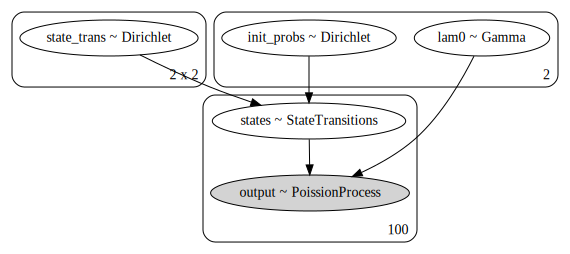

In [12]:
pm.model_to_graphviz(m)

## Fit

In [13]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=1, cores=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [state_trans, init_probs, lam0]
>BinaryGibbsMetropolis: [states]
Sampling chain 0, 0 divergences: 100%|██████████| 3000/3000 [01:32<00:00, 32.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [14]:
# with m:
#     ppc = pm.sample_posterior_predictive(trace)

In [15]:
_state = [0, 1]
_obs = list(range(100))

ifd = az.from_pymc3(
    trace=trace,
    # posterior_predictive=ppc,
    dims={
        'states': ['OBS'], 
        'output': ['OBS'],
        'lam0': ['STATE'], 
        'init_probs': ['STATE'],
        'state_trans': ['STATE', "AUX_STATE"]
    }, 
    coords={'STATE': _state, "AUX_STATE": _state}
)
ifd

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Check traces

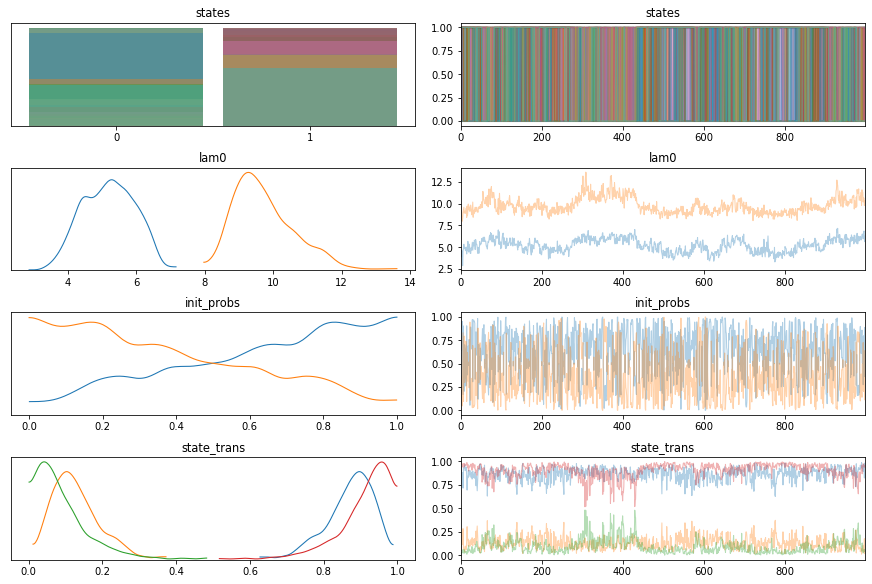

In [16]:
az.plot_trace(ifd, compact=True);

# Model testing

## Posterior values

In [17]:
ifd.posterior['state_trans'].mean(dim=['chain', 'draw']).values

array([[0.87011933, 0.12988067],
       [0.09301336, 0.90698664]])

In [18]:
ifd.posterior['lam0'].mean(dim=['chain', 'draw']).values

array([5.20158756, 9.76017578])

Posterior predictions for the process don't work, because PoissonProcess doesn't define `random()` and so pm sampling just takes the data values.

## Model fit

In [19]:
# HDI doesn't work
# az.hdi(ifd.posterior['states'], hdi_prob=0.5)  # .set_index(hdi=['lower', 'upper'])

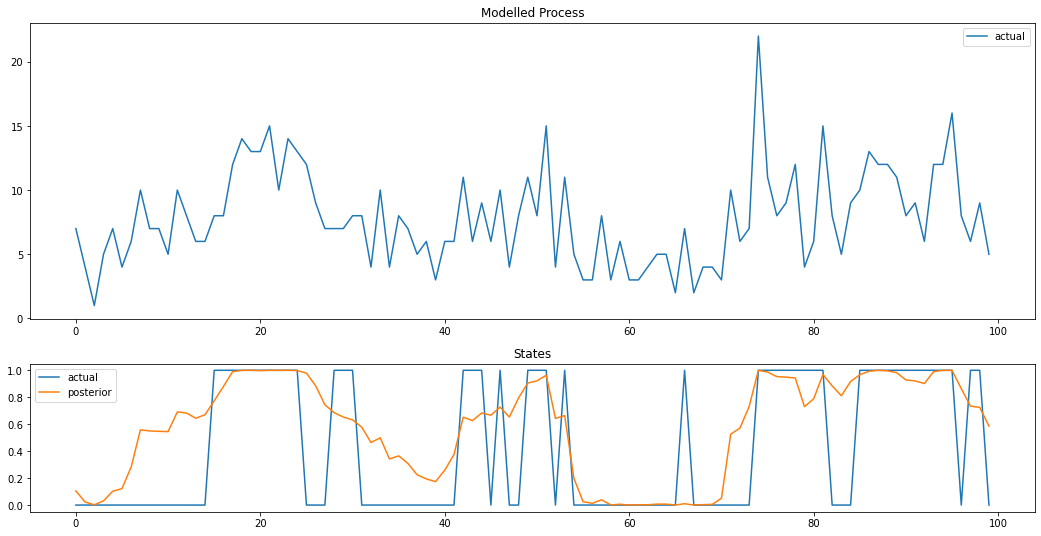

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(18, 9), gridspec_kw={'height_ratios': [2, 1]})

# 
df_simple['vals'].plot.line(ax=ax[0], color='C0', label='actual')
# TODO: Get range for process
ax[0].set_title("Modelled Process")
ax[0].legend()

df_simple['states'].plot.line(ax=ax[1], color='C0', label='actual')
ax[1].plot(
    ifd.posterior['states'].mean(dim=['chain', 'draw']).values,
    color='C1', label='posterior'
)
# TODO: 
ax[1].set_title("States")
ax[1].legend()
fig;